In [13]:
import casadi
import casadi as ca
import matplotlib.pyplot as plt
import cv2
import numpy as np
import yaml

with open('/home/nitesh/projects/ros2_ws/src/ros2_mpc/maps/map_carto.yaml', 'r') as file:
    params = yaml.safe_load(file)
map_image = cv2.imread('/home/nitesh/projects/ros2_ws/src/ros2_mpc/maps/map_carto.pgm')
# Change image to binary
ret, map_image = cv2.threshold(map_image, params['occupied_thresh'], 255, cv2.THRESH_BINARY)
# Convert it to grayscale
map_image = cv2.cvtColor(map_image, cv2.COLOR_BGR2GRAY)
# print(map_image.shape)
obstacles = np.array(np.where(map_image == 0)).T
map_info = {'resolution': params['resolution'], 'origin': params['origin'][:2]}
obstacles_xy = np.column_stack((obstacles[:, 1], map_image.shape[0] - obstacles[:, 0])) * map_info['resolution'] + \
               map_info['origin']
# Downsample the obstacles
obstacles_xy = obstacles_xy[::10, :]
print(obstacles_xy.shape)
obstacles_x = obstacles_xy[:, 0]
obstacles_y = obstacles_xy[:, 1]
# print(obstacles_xy.shape)
# # plt.imshow(map_image)
# plt.plot(obstacles_xy[:, 0], obstacles_xy[:, 1], 'r.')
# plt.show()

opti = ca.Opti()

# Define Parameters
ip_x = 0
ip_y = 0
it = 0
fp_x = 4
fp_y = 2
ft = 0

time_weight = 0.01
N = 100
# Define system states
# N = opti.variable()
x = opti.variable(N)
y = opti.variable(N)
theta = opti.variable(N)
dt = opti.variable()

# Define controls
v = opti.variable(N)
w = opti.variable(N)

obj = 0
for k in range(N):
    # for i in range(obstacles_x.shape[0]):
    hxy = ca.log(((x[k] - obstacles_x) / 0.2) ** 2 + (
            (y[k] - obstacles_y) / 0.2) ** 2)
    hxy = casadi.sum1(ca.exp(-hxy))
    obj = obj + ca.exp(hxy * 1.0)

print("Obj shape:", obj.shape)
# Define cost
opti.minimize(
    # time_weight * (N * dt) ** 2 +
    dt / 2 * (ca.sumsqr(v[0:N - 1]) + ca.sumsqr(v[1:N])) +
    dt / 2 * (ca.sumsqr(w[0:N - 1]) + ca.sumsqr(w[1:N])) +
    casadi.sum1(obj)
)

# Define constraints
g = x[1:] - x[:-1] - (v[:-1] * ca.cos(theta[:-1]) + v[1:] * ca.cos(theta[1:])) * dt / 2
p = y[1:] - y[:-1] - (v[:-1] * ca.sin(theta[:-1]) + v[1:] * ca.sin(theta[1:])) * dt / 2
q = theta[1:] - theta[:-1] - (w[:-1] + w[1:]) * dt / 2

opti.subject_to(g == 0)
opti.subject_to(p == 0)
opti.subject_to(q == 0)
opti.subject_to(x[0] == ip_x)
opti.subject_to(x[-1] == fp_x)
opti.subject_to(y[0] == ip_y)
opti.subject_to(y[-1] == fp_y)
opti.subject_to(theta[0] == it)
opti.subject_to(theta[-1] == ft)
opti.subject_to(dt > 0.0)
opti.subject_to(dt <= 0.1)
opti.bounded((-ca.pi / 4), w, (ca.pi / 4))
opti.bounded(-0.1, v, 0.1)
opti.subject_to(v[0] == 0)
opti.subject_to(v[-1] == 0)
for k in range(N-1):
    opti.subject_to((x[k] - x[k+1]) <= ca.fabs(0.1))



(346, 2)
Obj shape: (1, 1)


In [14]:
# # Define Solver and Solve
opti.solver('ipopt')
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1889
Number of nonzeros in inequality constraint Jacobian.:      200
Number of nonzeros in Lagrangian Hessian.............:     1000

Total number of variables............................:      501
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      305
Total number of inequality constraints...............:      101
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      100

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.7045194e+02 4.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

[-1.17152878e-36  2.85060223e-03  2.59913689e-02  7.56031677e-02
  1.36718126e-01  1.98925613e-01  2.56637252e-01  3.07626993e-01
  3.51529900e-01  3.88838377e-01  4.20351808e-01  4.46911932e-01
  4.69291797e-01  4.88159744e-01  5.04077047e-01  5.17508838e-01
  5.28838858e-01  5.38383928e-01  5.46406625e-01  5.53125790e-01
  5.58724990e-01  5.63359234e-01  5.67160267e-01  5.70240739e-01
  5.72697499e-01  5.74614224e-01  5.76063523e-01  5.77108654e-01
  5.77804935e-01  5.78200928e-01  5.78339437e-01  5.78258375e-01
  5.77991515e-01  5.77569167e-01  5.77018782e-01  5.76365512e-01
  5.75632735e-01  5.74842555e-01  5.74016291e-01  5.73174958e-01
  5.72339767e-01  5.71532628e-01  5.70776697e-01  5.70096948e-01
  5.69520806e-01  5.69078849e-01  5.68805580e-01  5.68740313e-01
  5.68928167e-01  5.69421224e-01  5.70279846e-01  5.71574232e-01
  5.73386230e-01  5.75811500e-01  5.78962101e-01  5.82969647e-01
  5.87989199e-01  5.94204153e-01  6.01832495e-01  6.11134957e-01
  6.22425877e-01  6.36087

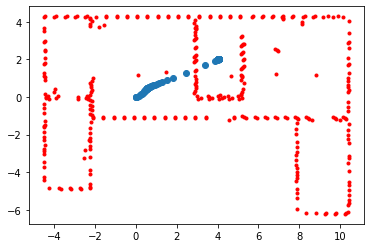

In [15]:
x = sol.value(x)
y = sol.value(y)
print(x)
print(sol.value(dt))
#
# # Plot
plt.plot(obstacles_x, obstacles_y, 'r.')
plt.plot(x, y, 'o')
plt.show()